## <u>Contributions :</u>

Mabel Choi Jingyi
- Generate postive-negative pairs
- Building Data Loading Codes
- Building Optimiser & Scheduler Codes
- Formatting of Jupyter Notebook

Choi Shu Yih, Jordan
- Generate postive-negative pairs
- Building Model Training Codes
- Optimising and finetuning hyperparamters
- Training the model

Koh Tzi Yang
- Generate postive-negative pairs
- Building Test Codes
- Formatting of Jupyter Notebook
- Rerunning code cells


## <u>Step 1: Install Necesscary Packages and Setting up Environment</u>
This step (installing necessary packages) is required as this will ensure that all required and relevant Python Libraries and Packages are ready and installed in the environment for running the DPO training.

### <u>Step 1.1: Allow Google Drive Access to Google Collab Environment</u>

Since our own computational resources are not good enough for the training of this NanoGPT model, we made use of Google Collab, which offers free access to powerful hardware resources and real-time collaboration, which are crucial for accelerating the task of training the NanoGPT model. 

In [ ]:
### Mount Google Drive to the Google Collab environment ###

# This step is necessary as it will ensure that the notebook has read and write access to the \
# Google Drive containing the project's assets
# - Load the dataset file and the pre-trained NanoGPT weights and checkpoints
# - Save and reload the DPO's fine-tuned checkpoints (dpo.pt with model weights)

# Successful mounting will resulted in a "Mounted at /content/drive" output
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <u>Step 1.2: Install Relevant Packages</u>

For this step, we will be installing the necessary Python Packages that will be able to allow us to achieve different tasks:
- _**matplotlib**_: For data visualisation and plotting the training metrics
- _**torch**_: PyTorch's deep learning framework for model training
- _**numpy**_: Numerical computing library
- _**transformers**_: Used for tokenisation utilities
- _**datasets**_: Used for data loading and processing
- _**tiktoken**_: Tokenisation library
- _**wandb**_: Weights and biases, used for experiment tracking
- _**tqdm**_: Progress bar library, used for monitoring training loops

In [ ]:
!pip install matplotlib
!pip install torch numpy transformers datasets tiktoken wandb tqdm
#%pip uninstall -y torch torchvision torchaudio
#%pip install --index-url https://download.pytorch.org/whl/cu124 torch torchvision torchaudio

ERROR: Operation cancelled by user


## <u>Step 2: Package Imports and Configuration</u>

This step (Package Imports and Configuration) is necessary as loading the packages to be used is required for usage of the packages. Additionally, setting up and configurating the hyperparameters were also necessary for the DPO training process.

### <u>Step 2.1: Confirming Configuration</u>

This step is necessary as we would need to confirm that we have the necessary computational power, and make sure that we are in the correct working directory and make sure that we have all the necessary packages imported before we can start with the model training.

In [ ]:
### GPU Verification ###
# This step will allow us to display and view information about the available GPU
# - Information regarding the GPU's model and driver version, etc
# - This will also let us know if Google Collab is able to provide us with the computational power \
# needed for the NanoGPT model training

!nvidia-smi

Mon Oct 20 15:31:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             63W /  400W |    3093MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Based on the output that was returned above, from querying for the resources available in the Google Collab notebook, we can confirm that a Nvidia GPU with CUDA 12.4 is available, thus, providing the sufficient computational power that we need for training the NanoGPT model.

In [ ]:
### Change Directory ###
# - This step will also list the contents, thus, allowing us to confirm we are in the correct \
# and relevant directory so the relative paths can resolve. (eg. 'sft/gpt.pt')
# - Before proceeding with the actual training portion of the DPO model, we would need to \
# change directory to the folder that contains our dataset and pre-trained NanoGPT model

!ls
%cd /content/drive/MyDrive/Colab Notebooks/Lab-1 NEW/SC3000_TECD2_Lab1_NanoGPT-Math-NEW
!ls

configurator.py  data  dpo  model.py  __pycache__  README.md  sft
/content/drive/MyDrive/Colab Notebooks/Lab-1 NEW/SC3000_TECD2_Lab1_NanoGPT-Math-NEW
configurator.py  data  dpo  model.py  __pycache__  README.md  sft


Based on the above output that was returned, we can confirm that we are in the correct working directory and we can continue to the next step on importing the required necessary packages.

### <u>Step 2.2: Importing required necessary packages, Hyperparameter Configuration, and Tokeniser Loading</u>

#### Step 2.2.1: Importing Required Packages
For the first part of this step, we will need to import the relevant necessary packages to achieve different tasks:
- _**PyTorch modules**_: Required for neural network operations
- _**Pickle and JSON**_: For data serialisation
- _**GPT and GPTConfig**_: Classes from model.py
- _**tqdm**_: Progress bar library, used for monitoring training loops
- _**matplotlib**_: For data visualisation and plotting the training metrics

#### Step 2.2.2: Hyperparameter Configuration
This contains the fine-tuning data for the DPO model.
- _**beta**_: This is the DPO temperature parameter that controls the strength of preference learning. For beta values, the higher the value the more conservative the learning, whereas, the lower the value the more aggressive the learning.
    - For us, we set it to 0.5, as it will be able to provide a good balance for the learning whereby it is aggressive enough to learn the preferences effectively but at the same time it is also not so aggressive whereby it will cause training instability.
- _**base lr**_: This is the learning rate that is for the AdamW optimiser
    - For us, we set it to 2e-4 = 0.0002, which allows for faster convergence during the DPO model training. Additionally, since we are not completely retraining the model, this learning rate enables efficient adaptation without catastrophic forgetting of the pre-trained weights and knowledge.
- _**epochs**_: This refers to the number of complete passing through of the dataset. 
    - For us, we set the number of epochs to 10 as it will then provide a sufficient training time for the NanoGPT model to learn mathematical reasoning patterns.
    - Fewer epochs, such as 3 epochs, might result in incomplete training for the NanoGPT model, while more epochs, such as 20 epochs, might result in overfitting, where the model will memorise the examples rather than generalising it.
- _**batch size**_: This refers to the amount of pos-neg data pairs that are processed simultaneously per gradient update.
    - For us, we chose this batch size to maximise the GPU's memory utilisation without any overflow.
    - This batch size ensures consistent batch statistics across training, and provides a stable gradient estimates, as larger batches might give a noisier gradients.
- _**max length**_: This refers to the maximum sequence length for the input sequences. This is because most of our mathematical problems are within the length we have set (64), thus, allowing for efficient batched processing.
    - Essentially, every one of our sequence will be set to max 64 in length, whereby the sequences longer than 64 will be truncated, whereas the shorter sequences will be padded with zeros.
- _**num samples**_: This refers to the number of response samples to geenrate per prompt during the model's evaluation.
    - For us, we set this value to 1, for efficiency during the testing phase.
- _**max new tokens**_: This refers to the maximum number of tokens to be generated during inference.
    - For us, we set it to 200, as this limit ensures complete answers with explanations included, while preventing infinite loops generation at the same time. 
- _**temperature**_: This controls the randomness in the text generations.
    - Lower temperatures are usually used for deterministic problems, whereby the most likely token is preferred.
    - Higher temperatures are usually used for when diverysity is desired, such as creative writing.
    - For us, we set the temperature to be 0.1, which is a very low temperature, thus, making the generation highly deterministic and focused. For mathematical problems, we are looking for precise and correct answers, thus, lower temperatures would ensure that the model consistently geenrates the most probable and correct responses.
- _**top k**_: This refers to how much of the tokens in the vocabulary are or will be considered during generation. 
    - For us, we disabled top k sampling, so all of the tokens in the vocabulary are considered during generation.
    - For math problems, there is no need to artifically restrict the vocabulary, and together with the low temperature, it already guarantee more or less a focused generation. Thus, we set it to None, so that the model can have full flexibility in choosing the correct mathematical terms, numbers and words used for explanations.

#### Step 2.2.3: Tokeniser Loading
This tokeniser will load the character-level vocabulary from the pre-trained NanoGPT Model.
- _**stoi**_: maps the characters to token IDs
- _**itos**_: maps token IDs back to characters
- _**encode**_: converts text strings to token ID sequences
- _**decode**_: converts token ID sequences back to text strings

In [ ]:
### Step 2.2.1 - Importing Required Packages ###
import sys
import os
sys.path.append(os.path.abspath(".."))
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import json
import random
from model import GPT, GPTConfig
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

### Step 2.2.2 - Hyperparameter Configuration ###
beta = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 2e-4
epochs = 10
batch_size = 64
max_length = 64
num_samples = 1
max_new_tokens = 200
temperature = 0.1
top_k = None


### Checking Available Resource ###
# check that there is GPU available and can be used for training in the later step
print(device)
print("torch cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    import subprocess
    print("device name:", torch.cuda.get_device_name(0))
    x = torch.randn(8192, 8192, device="cuda")
    y = x @ x
    print("tensor on:", y.device)
    subprocess.run(["nvidia-smi"])


### Step 2.2.3 - Tokeniser Loading ###
with open("sft/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

cuda
torch cuda available: True
device count: 1
device name: NVIDIA A100-SXM4-80GB
tensor on: cuda:0


## <u>Step 3: Define helper functions</u>

In [72]:
def compute_logprob(input_ids):
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]
    logits, _ = gpt(inputs, full_seq=True)
    B, T, V = logits.size()
    logits_flat = logits.reshape(-1, V)
    targets_flat = targets.reshape(-1)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=0, reduction='none')
    loss = loss.reshape(B, T)
    attention_mask = (targets != 0).float()
    loss = (loss * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
    return -loss

def pad_or_truncate(seq, max_length):
    return seq[-max_length:] if len(seq) > max_length else seq + [0] * (max_length - len(seq))

def get_batches(lines, batch_size):
    random.shuffle(lines)
    #for l in lines:
    #    print(l[1])
    for i in range(0, len(lines), batch_size):
        batch = lines[i:i+batch_size]
        if len(batch) < batch_size:
            continue
        neg_inputs = [pad_or_truncate(encode(p['negative'] + '\n\n\n\n'), max_length) for p in batch]
        pos_inputs = [pad_or_truncate(encode(p['positive'] + '\n\n\n\n'), max_length) for p in batch]
        neg_tensor = torch.tensor(neg_inputs, dtype=torch.long, device=device)
        pos_tensor = torch.tensor(pos_inputs, dtype=torch.long, device=device)
        yield neg_tensor, pos_tensor

## <u>Step 4: Load the pretrained NanoGPT model</u>

This step will load the pre-trained NanoGPT model that will serve as the starting point for the DPO model training

In [73]:
ckpt = torch.load("sft/gpt.pt", map_location=device)
gptconf = GPTConfig(**ckpt['model_args'])
gpt = GPT(gptconf)
state_dict = ckpt['model']
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
gpt.to(device).train()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(74, 348)
    (wpe): Embedding(256, 348)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=348, out_features=1044, bias=False)
          (c_proj): Linear(in_features=348, out_features=348, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=348, out_features=1392, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1392, out_features=348, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=348, out_features=74, bias=False)
)

## <u>Step 5: Load Data (**students are required to complete this part!**)</u>

In this step, we will generate the dataset consisting of the positive and negative datapairs, and load the dataset as well, which will be used to train the DPO model.

This step is crucial as it is the foundation for the DPO model training. We would need to create a large-scale dataset of positive and negative data pairs whereby the positive examples represent the correct mathematical solutions to mathematics problems with explanations, and negative examples represent incorrect or confused response to mathematics problems.

### <u>Step 5.1: Dataset Generation</u>

For our _**generation of the positive and negative data pairs dataset**_, we initially created a **2-phased approach**.
- _**Phase 1**_ would focus on the basic arithmetic and simple linear equations to come up with basic foundational mathematical reasonings
- Then _**Phase 2**_ would gradually introduce more complex arithmetic operations

This hopefully would be able to help the model to learn basic fundemental mathematical arithmetic patterns first, before tackling the more complex operations; similar to how humans learn math.

However, for our final dataset that we used, we decided to turn off the phase 2 dataset generation as the model seemed to learn and perform better with the easier dataset.

In this step, we will programmatically build a data pair dataset consisting of 250,000 pairs of positive and negative math data.



In [ ]:
# Data Pairs Generation
# Ensure packages imported
import random, json, re


### Configuration ###
# We generate 250,000 training pairs as this would be large enough for robust learning and generalisation
TOTAL = 250000
# Seed is used for the reproducibility of datasets
SEED = 20251020
# Ratios for different Phases
RATIOS = {
    # Phase 1 ratios
    "arithmetic_1step": 0.60, # addotion, subtraction, multiplication, division
    "linear_eqn":       0.40, # solving for x in simple equations

    # Phase 2 ratios - turned off due to complexity and model's inability to learn from these expressions
    "expression_2steps": 0.00,
    "edge_cases":        0.00,
}
# Range limits for operands used in dataset
A_B_RANGE = (1, 50)     # operands for arithmetic operations - range is small enough to avoid large number challenges and large enough to ensure generalisation, small ranges also helped the model to learn patterns quickly
X_K_B_RANGE = (1, 20)   # operands for linear equations - range is small enough to keep algebric problems manageable and prevents complex multi-digit calculations


### Helper Functions ###
# Arithmetic Generation Function (Phase 1)
def gen_arithmetic():
    a = random.randint(*A_B_RANGE) # get random operand a
    b = random.randint(*A_B_RANGE) # get random operand b
    op = random.choice(['+','-','*','/']) # get random operator for a and b; equal probability
    
    # generate problems
    if op == '/':
        # only generate division problems with integer results - tokeniser might struggle with decimals
        divisors = [d for d in range(1, A_B_RANGE[1]+1) if a % d == 0] # find all divisors of a, and randomly select one of the divisors as b
        b = random.choice(divisors) if divisors else 1 # if there is no divisor of a, default to b = 1
        ans = a // b # ensure whole number results
    elif op == '+': ans = a + b
    elif op == '-': ans = a - b
    else:           ans = a * b
    
    # create prompt structure as a standard math question format
    prompt = f"{a}{op}{b}=?"
    # generate positive result with answer from previous section and form as a structured output - model will learn to give reasoning as well during model testing
    pos = f"{prompt} The answer is {ans} because {a}{op}{b} equals {ans}."
    # generate negative result with wrong answer
    if random.random() < 0.5: # based on randomness, generate common miscalculations - stimulates common calculation errors
        wrong = ans + random.choice([-3, -2, -1, 1, 2, 3])
        neg = f"{prompt} The answer is {wrong}."
    else: # still generate a response instead of giving up - like the pre-trained NanoGPT model
        neg = f"{prompt} Sorry, I do not know!"
    
    return {"negative": neg, "positive": pos}

# Linear Equation Generation Function (Phase 1)
def gen_linear():
    # three patterns for linear equations: x+b=c, x-b=c, x*k=c
    pat_choice = random.choice([0,1,2]) # get a random choice of pattern; equal probability

    # generate problems with positive results
    if pat_choice in (0,1): # if pattern choice is 0 or 1, will be a + or - operation
        x = random.randint(*X_K_B_RANGE) # get random operand x (ans)
        b = random.randint(*X_K_B_RANGE) # get random operand b
        if pat_choice == 0: # addition linear equation if choice is 0
            c = x + b
            prompt = f"x+{b}={c},x=?"
        else: # subtraction linear equation if choice is 1
            c = x - b
            prompt = f"x-{b}={c},x=?"
        ans = x
        # generate positive result with answer from previous section and form as a structured output - model will learn to give reasoning as well during model testing
        pos = f"{prompt} The answer is {ans} because {c}{'-' if pat_choice==0 else '+'}{b} equals {ans}." # inverse + and -, to find the answer
    else: # else it will be a multiplication linear equation if choice is 2
        k = random.randint(1, X_K_B_RANGE[1]) # get random operand k
        x = random.randint(*X_K_B_RANGE) # get random operand x (ans)
        c = k * x
        prompt = f"{k}*x={c},x=?"
        ans = x
        # generate positive result with answer from previous section and form as a structured output - model will learn to give reasoning as well during model testing
        pos = f"{prompt} The answer is {ans} because {c}/{k} equals {ans}."
    
    # generate negative result with wrong answer
    if random.random() < 0.5: # based on randomness, generate common miscalculations - stimulates common calculation errors
        wrong = ans + random.choice([-3,-2,-1,1,2,3])
        neg = f"{prompt} The answer is {wrong}."
    else: # still generate a response instead of giving up - like the pre-trained NanoGPT model
        neg = f"{prompt} Sorry, I do not know!"
    return {"negative": neg, "positive": pos}

# Phase 2 - This phase will NOT BE USED in our FINAL DATASET as we realised that the model learns better with the basic fundemental mathematical arithmetic patterns
# However, we will still go through our logic in implementing these functions
# The implementation is not as in-depth as our 'Phase 1' definition implementations as we originally only came up with data pair datasets that gives the correct answers for positive and "Sorry, I do not know!" for negative
# The implementation for the 'Phase 1' was more in-depth as we wanted to test out the model's capability to learn common errors and not make the same errors
# Since the model cannot seem to learn as well from these complex equations, we did not implement more in-depth codes for the 'Phase 2' definition functions
# 2 Steps Expression Generation
def gen_expression_2steps(): # this function creates expressions that requires knowledge of order of mathematical operations (eg. BODMAS)
    a,b,c = [random.randint(1,9) for _ in range(3)] # generate random operands
    op1, op2 = random.choice(['+','-','*']), random.choice(['+','-','*']) # generate random operators
    prompt = f"{a}{op1}({b}{op2}{c})=?" # generate prompts that requires knowledge of order of mathematical operations (eg. BODMAS)
    ans = eval(f"{a}{op1}({b}{op2}{c})") # evaluate answer with Python's built in function
    pos = f"{prompt} The answer is {ans}." # generate positive result
    neg = f"{prompt} Sorry, I do not know!" # generate negative result
    return {"negative": neg, "positive": pos}
# Edge Cases Generation
def gen_edge_cases():
    # simple negatives only; range is kept small to keep problems manageable
    a = random.randint(-20, 20) # generate random operand a
    b = random.randint(-20, 20) # generate random operand b
    op = random.choice(['+','-','*']) # generate random operator
    prompt = f"{a}{op}{b}=?" # generate prompt based on random operands and operator, without doing checking if it goes to negative or is 0
    ans = eval(f"{a}{op}{b}") # evaluate answer with Python's built in function
    pos = f"{prompt} The answer is {ans}." # generate positive result
    neg = f"{prompt} Sorry, I do not know!" # generate negative result
    return {"negative": neg, "positive": pos}

# Dataset Building Functions
GENS = { 
    # as named in our ratios for different phases \
    # thus maps category names to generator functions
    "arithmetic_1step": gen_arithmetic,
    "linear_eqn": gen_linear,
    "expression_2steps": gen_expression_2steps,
    "edge_cases": gen_edge_cases,
}
def build_dataset(total=TOTAL, ratios=RATIOS):
    data = []
    # iterate through each of the categories in the different phases and ratios, and calculate total number of examples
    for k, r in ratios.items():
        n = int(total * r) # set the total number of example to variable n
        if n <= 0: continue # if there is no ratio allocated, skip
        # append each generated pair to the appropriate generator function, n times
        for _ in range(n):
            data.append(GENS[k]())
    
    # then randomise the order of all generated pair (no longer located with same problem types)
    random.shuffle(data)
    return data

# Build the final dataset
data = build_dataset()
print(f"Generated: {len(data)} pairs") # print to check dataset generated correctly


### Validation ###
# This is done to catch any possible generation bugs during the generation of the data pair dataset
# This is done with regular expression pattern matching
arith_re = re.compile(r'^(-?\d+)([+\-*/])(-?\d+)=\?$') # to check if it matches "number operator number = ?"
lin_add  = re.compile(r'^x\+(-?\d+)=(-?\d+),x=\?$') # to check if it matches "x + number = number, x = ?"
lin_sub  = re.compile(r'^x\-(-?\d+)=(-?\d+),x=\?$') # to check if it matches "x - number = number, x = ?"
lin_mul  = re.compile(r'^(\d+)\*x=(-?\d+),x=\?$') # to check if it matches "number * x = number, x = ?"

# Definition to extract only the question part before the answer
def extract_prompt(s):
    # get the part before the first space (answer)
    return s.split(' ', 1)[0]
# Definition to check if positive response actually contain the correct answer
def check_positive_record(rec):
    s = rec["positive"]
    prompt = extract_prompt(s)

    # to recalculate the answer given, and compare against the answer in the positive response
    m = arith_re.match(prompt)
    if m: # if it is arithmetic equation
        a, op, b = int(m.group(1)), m.group(2), int(m.group(3))
        ans = a+b if op=='+' else a-b if op=='-' else a*b if op=='*' else (a//b)
    else: # if it is linear equation
        m1 = lin_add.match(prompt)
        m2 = lin_sub.match(prompt)
        m3 = lin_mul.match(prompt)
        if m1:
            b, c = int(m1.group(1)), int(m1.group(2))
            ans = c - b
        elif m2:
            b, c = int(m2.group(1)), int(m2.group(2))
            ans = c + b
        elif m3:
            k, c = int(m3.group(1)), int(m3.group(2))
            ans = c // k
        else:
            # Other types are Phase 2, so skip
            return True

    return f" {ans}" in s  # check to see if actual answer exists in the resposne given

# Report any bad examples
bad = [i for i,rec in enumerate(data) if not check_positive_record(rec)] # this will identify any problematic records
# hence print out pass rate of the data pair dataset generated
print(f"Positives passing numeric sanity: {len(data)-len(bad)}/{len(data)}")
# if the pass rate check is less than 100%, it will print out the first 5 bad indices for debugging purposes
if bad[:5]: print("First 5 bad indices:", bad[:5])


### Save Generated Dataset to File ###
import os
os.makedirs("./data", exist_ok=True)
path = "./data/pos_neg_pairs.json"
with open(path, "w") as f:
    json.dump(data, f, indent=2)
print(f"Saved {path}")

Generated: 250000 pairs
Positives passing numeric sanity: 250000/250000
Saved ./data/pos_neg_pairs.json


### <u>Step 5.2: Load Data from './data/pos_neg_pairs.json'</u>

In this step, we will:
- 1. Open the json file and read the dataset file that contains the positive-negative pairs.
- 2. Parse the json file contents by converting it from the json format to python's list of dictionaries.
- 3. Store all training examples in variable 'lines'.
    - Each element in lines is a dictionary with 2 keys:
        - 'negative': Incorrect or undesirable response; "x-7=1,x=? Sorry, I do not know!"
        - 'positive': Correct or human preferred response; "x-7=1,x=? The answer is 8 because 1+7 equals 8."

In [ ]:
# Check the working directory that we are currently in
!ls

# Load data from ./data/pos_neg_pairs.json
path = "./data/pos_neg_pairs.json"
with open(path, "r", encoding="utf-8") as f:
    lines = json.load(f)

# Check the number of data pairs in the dataset that has been loaded into 'line'
print(f"Loaded {len(lines)} training pairs")

configurator.py  data  dpo  model.py  __pycache__  README.md  sft
Loaded 250000 training pairs


## <u>Step 6: Build the optimizer and scheduler (**students are required to complete this part!**)</u>

This step is crucial as it will configure the optimisation algorithm with selective weight decay and a learning rate schedule with warmup, that is required for stable and effective training of the DPO model.

In [ ]:
# Ensure that all necessary imports are done
import math
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

""" Referencing to Step 2.2.2 - Hyperparameter Configuration
beta = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 2e-4
epochs = 10
batch_size = 64
max_length = 64
num_samples = 1
max_new_tokens = 200
temperature = 0.1
top_k = None
"""

# calculation of batches per epoch; to determine training schedule
# since our dataset has 250,000 pairs, this will be 250,000 // 64 ≈ 3906 steps
# additionally, having the max() function, also ensures that it will prevent any cases where steps_per_epoch equals to 0
steps_per_epoch = max(1, len(lines) // batch_size) 

# calculation of total gradient updates across all epochs; this is important for learning rate scheduling as well as warmup calculations
# since our number of batches/steps per epoch is ≈ 3906 steps, and epochs = 10, the total training steps would be 3906 * 10
total_training_steps = steps_per_epoch * epochs

# calculation of warmup; this is done by gradually increasing the learning rate from near-zero value to base_lr value, to allow the model to ease into optimisation and prevent early training explosions that can come about with too much data overload at once in the beginning of training
# first 5% of training steps is around 1953 steps (5% * 39060)
# 5% will allow the training of the model to stabalise, as it is short enough to not waaste time, but sufficiently long enough to stabalise
warmup_iters = int(0.05 * total_training_steps)

# calculation of total steps needed for the learning rate decay schedule
# this is set to decay throughout the entire training of the model
# according to best practices, the learning rate decays throughout training, which can be seen from the GPT2 and GPT3 model, so we will follow that approach
lr_decay_iters = total_training_steps

# calculation of minimum learning rate
# this is set to 5% of base learning rate as we do not want the training to completely stop, this also makes the model make smaller adjustments towards the end
# 5% * 2e-1 = 0.00001
min_lr = base_lr * 0.05

# AdamW with proper decay
# for this step, we are following GPT2/GPT3's training best practices
decay, no_decay = [], [] # no decay = bias and normalisation layers, decay = all other weights
for n, p in gpt.named_parameters(): # n = param name, p = param tensor containing the weights
    # if params is not updated / trainable during training, skip; we only want to apply weight decay to trainable parameters
    if not p.requires_grad: 
        continue
    # if there is bias or layernorm, append to no decay
    if n.endswith("bias") or "ln" in n.lower() or "layernorm" in n.lower(): 
        no_decay.append(p) # bias and normalisation layers
    # if there consists of all other weights, append to decay
    else:
        decay.append(p) # all other weights

# move model to device before creating the optimiser as the optimiser needs to know the parameter device locations
gpt.to(device)

# Now we move onto creating the AdamW Optimiser
optimizer = AdamW(
    [{"params": decay, "weight_decay": 0.1}, # has regularisation, if there is decay; this prevents catastrophic forgetting and maintains the pre-trained knowledge
     {"params": no_decay, "weight_decay": 0.0}], # has no regularisation, if there is no decay
    # for the adamw hyperparameters
    # for the learning rate, we set it to the same as the base_lr, for faster DPO model adaptation
    lr=base_lr,
    # for the betas, we follow the standard for transformer models, such as the GPT model
    # for the first moment, beta1, it captures gradient direction, so we set 90% of weights to historical gradients, and 10% to current gradients
    # for the second moment, beta2, it captures gradient scale, so we set beta2 to 0.999, which is a very slow decay, thus, providing stable and adaptive learning rates
    betas=(0.9, 0.999),
    # for the epsilon, we set it to the standard 1e-8, which is the standard across deep learning models, since it is small enough to be invisible in normal computation, but large enough to be meaningful in any floating-point arithmetics
    eps=1e-8,
)

# Learning Rate Schedule Function
def lr_lambda(step):
    # linear warmup - this stabalises early training, by linearly increasing the learning rate from 0 to base_lr
    if step < warmup_iters: 
        return step / max(1, warmup_iters)
    
    # cosine decay - this ensures smooth and gradual decrease and maintains a higher learning rate for a longer period of time
    # cosine decay is also widely used in models like GPT3, which is why we decided to follow this method
    progress = (step - warmup_iters) / max(1, lr_decay_iters - warmup_iters)
    return max(min_lr / base_lr, 0.5 * (1.0 + math.cos(math.pi * progress))) # this prevents the learning rate from going below the min_lr

# creation of the scheduler
# the LambdaLR scheduler will apply the custom learning rate function as defined above which will be called after each optimiser step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# validate that all of the above steps ran smoothly with no errors
print("Optimizer and scheduler ready.")


### Tokeniser ###
# ensure package imported
import pickle
# load the vocabulary - char to ID and ID to char mappings
with open("sft/meta.pkl","rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# get Null chars as padding and falls back to 0 if '\x00' is not in the vocabulary - consistent padding to ensure predictable behaviour
PAD_ID = stoi.get('\x00', 0)

# thus now the encode function can handle out of vocabulary chars gracefully by mapping to the PAD_ID as defined above instead of crashing and giving us an error message
def encode(s: str):
    return [stoi.get(ch, PAD_ID) for ch in s]

def decode(ids):
    return ''.join(itos[i] for i in ids)

Optimizer and scheduler ready.


## Step 7: Begin training (**students are required to complete this part!**)

### <u>Step 7.1: Training the new model</u>

In order to train the model, we would need to compare the _**likelihood of a correct vs wrong answer**_ through the model's mean sequence log-probability at each training step. 

From there, we can then apply pairwise preference loss. This helps the model learn by replicating preference patterns found in the comparison data we have provided by pushing it to _**score positives > negatives**_. 

This formula is denoted as follows : 
<p style="text-align:center;"><em>L<sub>pref</sub> ​= −E[ log σ( <math><mfrac><mn>1</mn><mi>β</mi></mfrac></math>​( logp<sub>θ</sub>​(pos) − logp<sub>θ</sub>​(neg) ) ) ]</em></p>

_**E**_ refers to the expectation over the current training batch, and _**β**_ refers to the temperature/margin scale (in this case it is inversed).

For optimization, we would use AdamW with stable learning-rate schedule _*(refer to Step 6)*_. 

For each training step, we would: 

1. Zero the gradients from previous step 
2. Backpropagating the loss to compute the new gradients
3. Gradient clipping the norm to be 1.0 or below to make it stable
4. Use the gradients stored to update the parameters in AdamW
5. Adjust the learning rate for the next step based on schedule

As we are interested in the training curves, we recorded the loss per step and current LR. This is used for us to plot a graph later on and verify that the schedule and loss behave as expected.


In [ ]:
total_steps = len(lines) // batch_size

# Store the values so that we can look at learning rate and loss later in graph plot
loss_history = []
lr_history = []

for epoch in range(epochs):
    pbar = tqdm(get_batches(lines, batch_size))
    for step, (neg_tensor,pos_tensor) in enumerate(pbar):
        '''
        ###########################################################
        # Please complete the training code here!
        # Examples:
        # ...
        # neg_logprob
        # pos_logprob
        # loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1
        # ...
        ###########################################################
        '''

        # Move tensors to device (makes sure that its the same)
        neg_tensor = neg_tensor.to(device)
        pos_tensor = pos_tensor.to(device)

        # Compute log-probabilities with the helper provided in sample notebook
        pos_logprob = compute_logprob(pos_tensor)
        neg_logprob = compute_logprob(neg_tensor)

        ### DPO pairwise preference loss ###
        # What we are looking here for is for pos_logprob > neg_logprob. In this case, the margin is pos - neg.
        # When the margin is small or negative, this formula helps to penalise the model
        #
        loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1

        ### Record loss per step and current LR ###
        # We want to look at learning rate and loss n plot graph, hence we will be storing loss_val and current_lr as the model runs
        loss_val = loss.item()
        loss_history.append(loss_val)

        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        ### Optimising the model ###
        # 1. Clear the gradients
        optimizer.zero_grad()
        # 2. Backpropagate to compute the new gradients
        loss.backward()
        # 3. Gradient clipping
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        # 4. Apply AdamW optimiser
        optimizer.step()
        # 5. Apply learning rate scheduler
        scheduler.step()

        # This is used for visual purposes to display the most recent loss, so that we can view in real-time the change in loss as we train the model
        loss_val = loss.item()
        pbar.set_postfix({"loss": loss_val})

    # Once an epoch has passed, we save it as a checkpoint to dpo.pt
    ckpt_path = f"dpo.pt"
    torch.save({
        "model_state_dict": gpt.state_dict(),
        "model_args": ckpt['model_args'],
    }, ckpt_path)
    print(f"Saved checkpoint to {ckpt_path}")

3906it [02:55, 22.20it/s, loss=0.0206]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.22it/s, loss=0.0172]


Saved checkpoint to dpo/dpo.pt


3906it [02:56, 22.17it/s, loss=0.0147]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.23it/s, loss=0.014]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.24it/s, loss=0.0143]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.27it/s, loss=0.0141]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.23it/s, loss=0.0141]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.26it/s, loss=0.014]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.24it/s, loss=0.0138]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.26it/s, loss=0.0139]


Saved checkpoint to dpo/dpo.pt


### <u>Step 7.2: Plotting</u>

Once our model has finished training, we plot a graph to verify that the schedule and loss behave as expected. 

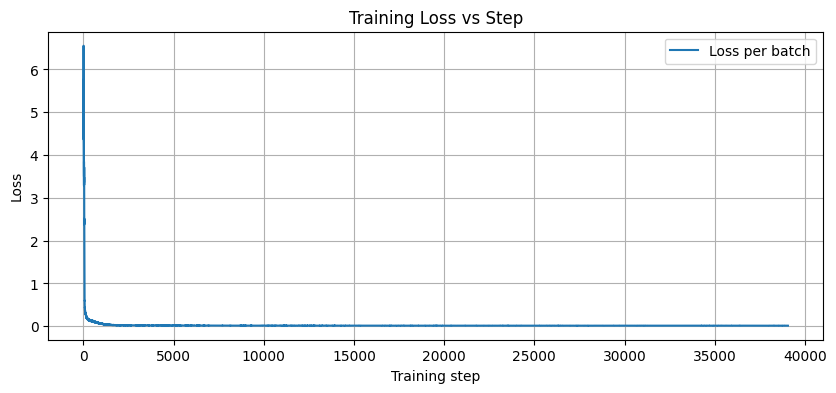

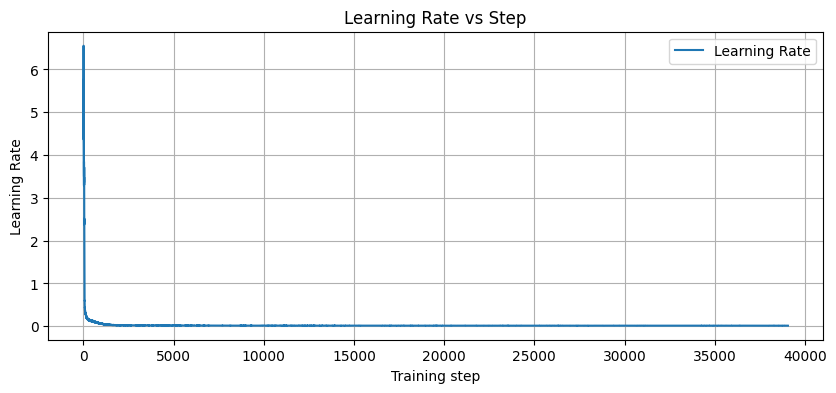

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss per step
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Loss per batch")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss vs Step")
plt.legend()
plt.grid(True)
plt.show()

# Plot learning rate schedule
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Learning Rate")
plt.xlabel("Training step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Step")
plt.legend()
plt.grid(True)
plt.show()


## Step 8: Begin testing (**students are required to complete this part!**)

#### For Testing, we looped through the following steps : 
1. Encode the prompt
2. Convert to tensor of token IDs
3. Run through model
4. Decode the output
5. Print results


In [ ]:
# Load the fine-tuned model
ckpt_path = "dpo.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])

# Added 'cpu' as potential device as most of us are using Macbook Apple Silicon
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt = GPT(gptconf).to(device)

try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)

# Test
gpt.eval()
test_set = ["17+19=?", "3*17=?", "72/4=?", "72-x=34,x=?", "x*11=44,x=?", "3*17=?", "72/4=?", "72-x=34,x=?", "8+12=?", "50-23=?", "9*8=?", "81/9=?", "x+15=30,x=?", "7*x=49,x=?", "5*6=?", "100/25=?", "x-7=15,x=?", "9+x=20,x=?", "12*12=?", "64/8=?", "x+9=18,x=?", "10*10=?", "45/5=?", "x-4=10,x=?", "x+7=14,x=?", "6*7=?", "81/9=?", "x-3=12,x=?", "8+x=15,x=?", "14*14=?", "72/8=?", "x+8=16,x=?", "9-3=?", "15*3=?", "81/9=?", "x-5=10,x=?", "x+6=13,x=?", "11*11=?", "56/7=?", "x+10=20,x=?", "7*8=?", "90/9=?", "x-2=8,x=?", "x+5=12,x=?", "13*13=?", "72/6=?", "x-6=14,x=?", "4*9=?", "81/9=?", "x+4=10,x=?", "8*8=?", "60/5=?", "x-1=9,x=?", "x+3=11,x=?", "9*9=?", "49/7=?", "x-4=11,x=?", "6*6=?", "100/10=?", "x+2=12,x=?", "15-7=?", "8*7=?", "72/9=?", "x-8=12,x=?", "x+1=10,x=?", "14*12=?", "54/6=?", "x-9=11,x=?", "5*8=?", "81/9=?", "x+12=20,x=?", "7*9=?", "80/8=?", "x-7=13,x=?", "x+11=22,x=?", "12*11=?", "63/7=?", "x-5=15,x=?", "9*7=?", "90/10=?", "x+15=25,x=?", "6*8=?", "72/8=?", "x-4=16,x=?", "x+14=28,x=?", "11*12=?", "48/6=?", "x-3=13,x=?", "4*8=?", "56/8=?", "x+13=26,x=?", "10*12=?", "70/7=?", "x-6=18,x=?", "x+9=19,x=?"]


with torch.no_grad():
    for prompt in test_set:
        prompt_ids = encode(prompt)
        '''
        # Please complete the test code here!
        # ...
        # gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        # ...
        '''

        # Converts the prompt to a tensor of token IDs based on our tokeniser
        x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, :]
        
        # Run through the trained model to generate the resultant tensor values
        y = gpt.generate(x, max_new_tokens=max_new_tokens, temperature=temperature,top_k=top_k)

        # We will take the tensor of token IDs and flatten it out to prep it for decoding
        ans = y[0].reshape(-1).tolist()

        # The output will be the decoded token IDs
        output = decode(ans)

        # Print out the prompt and output respectively
        print(f"PROMPT : {prompt}")
        print(f"OUTPUT : {output}")
        print("-" * 60)
        

PROMPT : 17+19=?
OUTPUT : 17+19=? The answer is 36 because 17+19 equals 36.
------------------------------
PROMPT : 3*17=?
OUTPUT : 3*17=? The answer is 51 because 3*17 equals 51.
------------------------------
PROMPT : 72/4=?
OUTPUT : 72/4=? The answer is 7 because 72/4 equals 7.
------------------------------
PROMPT : 72-x=34,x=?
OUTPUT : 72-x=34,x=? The answer is 16 because 34-7 equals 6.
------------------------------
PROMPT : x*11=44,x=?
OUTPUT : x*11=44,x=? The answer is 4 because 44/11 equals 4.
------------------------------
PROMPT : 3*17=?
OUTPUT : 3*17=? The answer is 51 because 3*17 equals 51.
------------------------------
PROMPT : 72/4=?
OUTPUT : 72/4=? The answer is 7 because 72/4 equals 7.
------------------------------
PROMPT : 72-x=34,x=?
OUTPUT : 72-x=34,x=? The answer is 16 because 34-7 equals 6.
------------------------------
PROMPT : 8+12=?
OUTPUT : 8+12=? The answer is 20 because 8+12 equals 20.
------------------------------
PROMPT : 50-23=?
OUTPUT : 50-23=? The 

#### For quick testing with text file, follow the steps and just run the cell below :
1. Ensure the test case are in a .txt file in the following format :<br>
<b>["17+19=?", "3*17=?", ... ,"72/4=?"]</b><br><br>
2. Edit the string_path variable<br><br>
3. Run the cell below

In [ ]:
# To be modified
string_path = "" 

# No editing required
import sys
import os
import pickle
sys.path.append(os.path.abspath(".."))
import torch
from model import GPT, GPTConfig

max_new_tokens = 200
temperature = 0.05
top_k = None

with open("../sft/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_path = "dpo.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
gpt = GPT(gptconf).to(device)
try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
gpt.eval()

try:
    with open(string_path, "r") as file:
        priv_set = file.read()
        
    with torch.no_grad():
        for prompt in priv_set:
            prompt_ids = encode(prompt)
            x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, :]
            y = gpt.generate(x, max_new_tokens=max_new_tokens, temperature=temperature,top_k=top_k)
            ans = y[0].reshape(-1).tolist()
            output = decode(ans)

            print(f"PROMPT : {prompt}")
            print(f"OUTPUT : {output}")
            print("-" * 60)

except FileNotFoundError:
    print("Error : File not found")
except IOError as e:
    print(f"Error : {e}")
        